In [1]:
from utils_synthetic import *
from scipy.special import binom as spb
%load_ext autoreload
%autoreload 2

In [ ]:
def is_subset(list_one, list_two):
    '''
        Input: 
            list_one <list>
            list_two <list>
        Output:
            bool, equal to 1 if list_one is a subset of list_two
    '''
    return len(np.intersect1d(list_one, list_two)) == len(list_one)

def jaccard_coefficient(list_one, list_two):
    '''
        Input: 
            list_one <list>
            list_two <list>
        Output:
            bool, equal to 1 if list_one is a subset of list_two
    '''
    return len(np.intersect1d(list_one, list_two))/len(set(list(list_one)+list(list_two)))

def smolkin_inclusion(data, method_dict, alpha_fraction = .5, metric = is_subset, num_boots = 100):
    
    '''
        Input: 
            data <array> of shape N, D where D is the dimensionality of the data
            method_dict <dictionary>
            alpha_fraction <float> in (0,1)
            metric <function>
            num_boots <int>
        Output:
            score <array> shape B, K - inclusion score proposed by Smolkin
    '''
    
    N,D = data.shape
    labels = repro_score(data, data, method_dict)[2]
    K = len(set(labels))
    score = np.zeros([num_boots,K])
    groups = [np.where(labels == k)[0] for k in range(K)]
    
    for b in tqdm_notebook(range(num_boots)):
        idx = np.random.choice(D, max(2,int(alpha_fraction*D)), replace = False)
        new_labels = repro_score(data[:,idx], data[:,idx], method_dict)[2]
        K_new = len(set(new_labels))
        new_groups = [np.where(new_labels == j)[0] for j in range(K_new)]
        for k in range(K):
            score[b,k] = np.sum([metric(groups[k], new_groups[k_prime]) for k_prime in range(K_new)])>=1
    
    return score, labels

def r_d_index(data, method_dict, variance_error_term, num_boots = 100):
    
    '''
        Input: 
            data <array> of shape N, D where D is the dimensionality of the data
            method_dict <dictionary>
            variance_error_term <float> in R+
            metric <function>
            num_boots <int>
        Output:
            score_r <array> shape B, K 
            score_d <array> shape B, K 
            labels <array> shape N
    '''
    
    N,D = data.shape # N: number of datapoints; D: dimension
    labels = repro_score(data, data, method_dict)[2] # original clusters labels
    K = len(set(labels)) # number of clusters in original clustering
    score_r = np.zeros([num_boots,K]) # empty array for score results
    score_d = np.zeros([num_boots,K]) # empty array for score results

    groups = [np.where(labels == k)[0] for k in range(K)] # clusters
    number_of_pairs = [spb(len(g),2) for g in groups] # list of length K; k-th entry is # pairs of points in k-th group
    
    for b in tqdm_notebook(range(num_boots)):
        new_data = data + np.random.multivariate_normal(np.zeros(D), variance_error_term*np.eye(D), size = N) # perturbed data
        new_labels = repro_score(new_data, new_data, method_dict)[2] # new clustering
        K_new = len(set(new_labels)) # new number of labels
        new_groups = [np.where(new_labels == j)[0] for j in range(K_new)] # new clusters
        for k in range(K): # for every old cluster
            
            size_intersections = [len(np.intersect1d(groups[k], new_groups[j])) for j in range(K_new)]
            paired_together = np.sum([spb(size_intersection, 2) for size_intersection in size_intersections])
            score_r[b,k] = paired_together/number_of_pairs[k] # fraction of points clustered together in k-th cluster of data also clustered together in new_data
            
            highest_overlap_index = np.argmax(size_intersections)
            score_d[b,k] = len(groups[k]) + len(new_groups[highest_overlap_index]) - 2 * size_intersections[highest_overlap_index] # number of deletions and additions in highest overlap group
    return score_r, score_d, labels


INIT = 'k-means++'
N_INIT = 50
MAX_ITER = 300
BATCH_SIZE = 100
TOLERANCE = .001
CCORE = True
METRIC = 'euclidean'
AFFINITY = 'euclidean'
LINKAGE = 'complete'

In [ ]:
# LOAD DATA

aggregation = np.loadtxt('Data/Shapes/aggregation.txt')
compound = np.loadtxt('Data/Shapes/compound.txt')
d31 = np.loadtxt('Data/Shapes/d31.txt')
flame = np.loadtxt('Data/Shapes/flame.txt')
jain = np.loadtxt('Data/Shapes/jain.txt')
pathbased = np.loadtxt('Data/Shapes/pathbased.txt')
r15 = np.loadtxt('Data/Shapes/r15.txt')
spiral = np.loadtxt('Data/Shapes/spiral.txt')

shapes_datasets, shapes_datasets_train, shapes_datasets_test = {}, {}, {}
shapes_datasets['aggregation'] = aggregation
shapes_datasets['compound'] = compound
shapes_datasets['d31'] = d31
shapes_datasets['flame'] = flame
shapes_datasets['jain'] = jain
shapes_datasets['pathbased'] = pathbased
shapes_datasets['r15'] = r15
shapes_datasets['spiral'] = spiral

In [ ]:
for ds in shapes_datasets:
    plt.figure()
    plt.title(ds)
    plt.scatter(shapes_datasets[ds][:,0], shapes_datasets[ds][:,1], s= 2)
    plt.show()

In [ ]:
smolkin_results = {}

smolkin_results['aggregation'] = {}
for n_cl in np.arange(3,10):
    
    method_dict = default_dictionary_kmeans(n_clusters = n_cl, init = INIT, n_init = N_INIT, max_iter = MAX_ITER)
    score, labels = smolkin_inclusion(aggregation, method_dict, alpha_fraction=1, metric = is_subset, num_boots = 200)
    smolkin_results['aggregation'][n_cl] = {}
    smolkin_results['aggregation'][n_cl]['score'] = score
    smolkin_results['aggregation'][n_cl]['labels'] = labels 
    
smolkin_results['compound'] = {}
for n_cl in np.arange(3,10):
    
    method_dict = default_dictionary_kmeans(n_clusters = n_cl, init = INIT, n_init = N_INIT, max_iter = MAX_ITER)
    score, labels = smolkin_inclusion(compound, method_dict, alpha_fraction=1, metric = is_subset, num_boots = 200)
    smolkin_results['compound'][n_cl] = {}
    smolkin_results['compound'][n_cl]['score'] = score
    smolkin_results['compound'][n_cl]['labels'] = labels 
    
smolkin_results['r15'] = {}
for n_cl in np.arange(5,20):
    
    method_dict = default_dictionary_kmeans(n_clusters = n_cl, init = INIT, n_init = N_INIT, max_iter = MAX_ITER)
    score, labels = smolkin_inclusion(r15, method_dict, alpha_fraction=1, metric = is_subset, num_boots = 200)
    smolkin_results['r15'][n_cl] = {}
    smolkin_results['r15'][n_cl]['score'] = score
    smolkin_results['r15'][n_cl]['labels'] = labels 
    
np.save('Additional_Experiments/smolkin_results', smolkin_results)

In [ ]:
jaccard_results = {}

jaccard_results['aggregation'] = {}
for n_cl in np.arange(3,10):
    
    method_dict = default_dictionary_kmeans(n_clusters = n_cl, init = INIT, n_init = N_INIT, max_iter = MAX_ITER)
    score, labels = smolkin_inclusion(aggregation, method_dict, alpha_fraction=1, metric = jaccard_coefficient, num_boots = 200)
    jaccard_results['aggregation'][n_cl] = {}
    jaccard_results['aggregation'][n_cl]['score'] = score
    jaccard_results['aggregation'][n_cl]['labels'] = labels 
    
jaccard_results['compound'] = {}
for n_cl in np.arange(3,10):
    
    method_dict = default_dictionary_kmeans(n_clusters = n_cl, init = INIT, n_init = N_INIT, max_iter = MAX_ITER)
    score, labels = smolkin_inclusion(compound, method_dict, alpha_fraction=1, metric = jaccard_coefficient, num_boots = 200)
    jaccard_results['compound'][n_cl] = {}
    jaccard_results['compound'][n_cl]['score'] = score
    jaccard_results['compound'][n_cl]['labels'] = labels 
    
jaccard_results['r15'] = {}
for n_cl in np.arange(5,20):
    
    method_dict = default_dictionary_kmeans(n_clusters = n_cl, init = INIT, n_init = N_INIT, max_iter = MAX_ITER)
    score, labels = smolkin_inclusion(r15, method_dict, alpha_fraction=1, metric = jaccard_coefficient, num_boots = 200)
    jaccard_results['r15'][n_cl] = {}
    jaccard_results['r15'][n_cl]['score'] = score
    jaccard_results['r15'][n_cl]['labels'] = labels 
    
np.save('Additional_Experiments/jaccard_results', jaccard_results)

In [ ]:
d_r_scores_results = {}

N, D = aggregation.shape
variance_error_term = .5*aggregation.std(axis = 0)
perturbed_aggregation = aggregation +  np.random.multivariate_normal(np.zeros(D), variance_error_term*np.eye(D), size = N)
plt.scatter(aggregation[:,0], aggregation[:,1], s = 2)
plt.scatter(perturbed_aggregation[:,0], perturbed_aggregation[:,1], s = 2)
plt.show()

d_r_scores_results['aggregation'] = {}
for n_cl in np.arange(3,10):
    variance_error_terms = 0.5*np.std(aggregation, axis = 0)
    method_dict = default_dictionary_kmeans(n_clusters = n_cl, init = INIT, n_init = N_INIT, max_iter = MAX_ITER)
    score_r, score_d, labels = r_d_index(aggregation, method_dict, variance_error_term, num_boots = 200)
    d_r_scores_results['aggregation'][n_cl] = {}
    d_r_scores_results['aggregation'][n_cl]['score_r'] = score_r
    d_r_scores_results['aggregation'][n_cl]['score_d'] = score_d
    d_r_scores_results['aggregation'][n_cl]['labels'] = labels 
    
N, D = compound.shape
variance_error_term = .5*compound.std(axis = 0)
perturbed_compound = compound +  np.random.multivariate_normal(np.zeros(D), variance_error_term*np.eye(D), size = N)
plt.scatter(compound[:,0], compound[:,1], s = 2)
plt.scatter(perturbed_compound[:,0], perturbed_compound[:,1], s = 2)
plt.show()    

d_r_scores_results['compound'] = {}
for n_cl in np.arange(3,10):
    variance_error_terms = 0.5*np.std(compound, axis = 0)
    method_dict = default_dictionary_kmeans(n_clusters = n_cl, init = INIT, n_init = N_INIT, max_iter = MAX_ITER)
    score_r, score_d, labels = r_d_index(compound, method_dict, variance_error_term, num_boots = 200)
    d_r_scores_results['compound'][n_cl] = {}
    d_r_scores_results['compound'][n_cl]['score_r'] = score_r
    d_r_scores_results['compound'][n_cl]['score_d'] = score_d
    d_r_scores_results['compound'][n_cl]['labels'] = labels 

N, D = r15.shape
variance_error_term = .5*r15.std(axis = 0)
perturbed_r15 = r15 +  np.random.multivariate_normal(np.zeros(D), variance_error_term*np.eye(D), size = N)
plt.scatter(r15[:,0], r15[:,1], s = 2)
plt.scatter(perturbed_r15[:,0], perturbed_r15[:,1], s = 2)
plt.show()
    
d_r_scores_results['r15'] = {}
for n_cl in np.arange(5,20):
    variance_error_terms = 0.5*np.std(r15, axis = 0)
    method_dict = default_dictionary_kmeans(n_clusters = n_cl, init = INIT, n_init = N_INIT, max_iter = MAX_ITER)
    score_r, score_d, labels = r_d_index(r15, method_dict, variance_error_term, num_boots = 100)
    d_r_scores_results['r15'][n_cl] = {}
    d_r_scores_results['r15'][n_cl]['score_r'] = score_r
    d_r_scores_results['r15'][n_cl]['score_d'] = score_d
    d_r_scores_results['r15'][n_cl]['labels'] = labels 
    
np.save('Additional_Experiments/d_r_scores_results', d_r_scores_results)

### NEXT, PLOTS

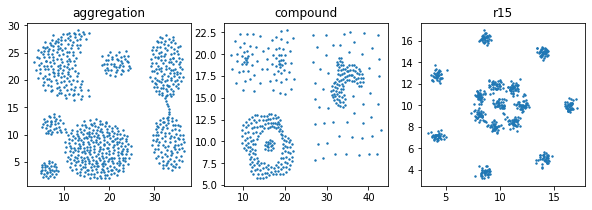

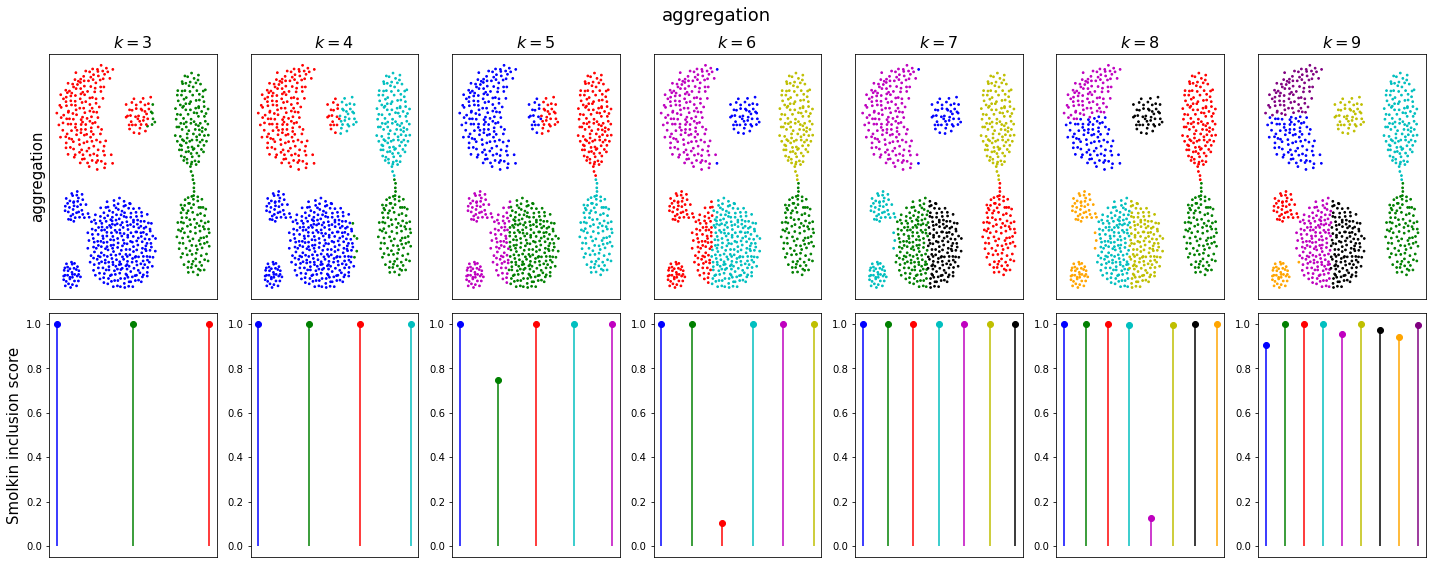

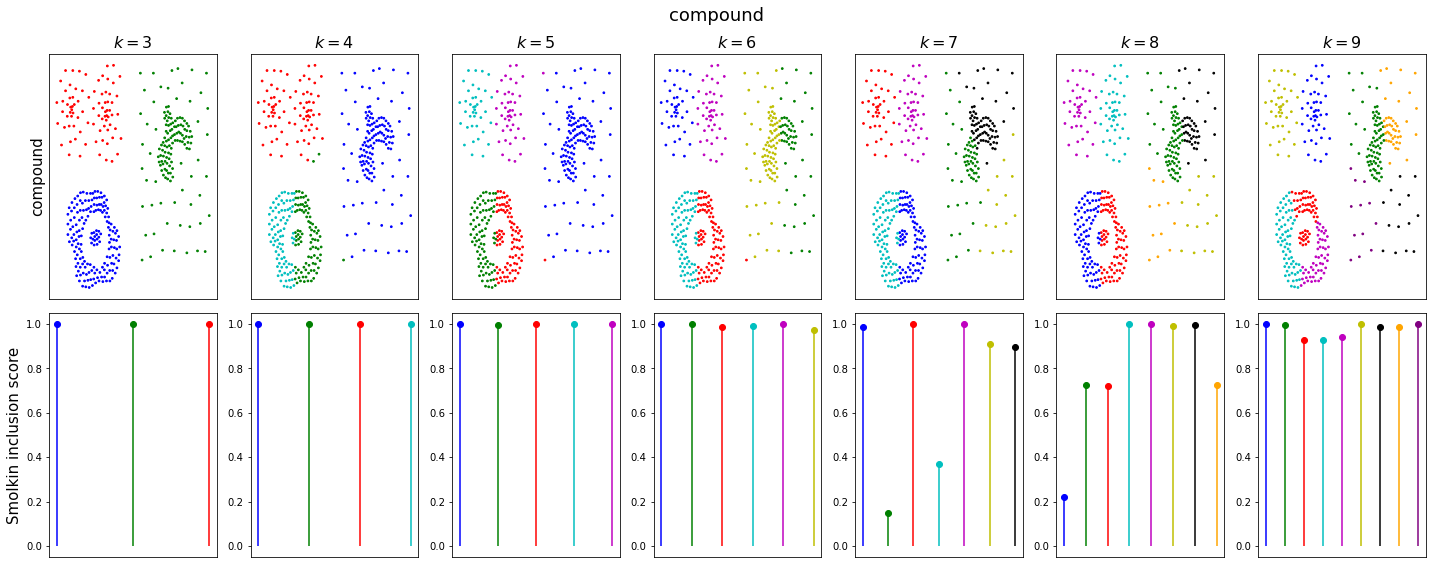

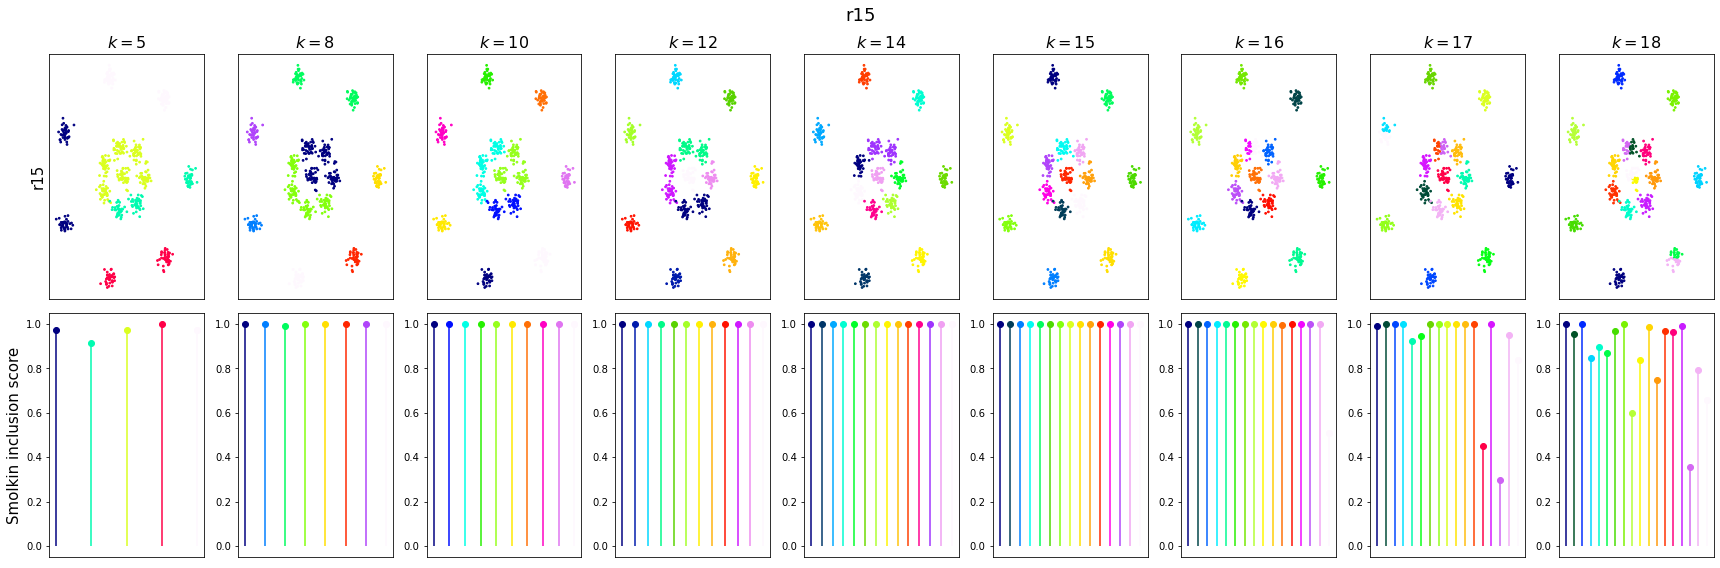

In [3]:
from matplotlib import cm

# LOAD DATA

aggregation = np.loadtxt('Data/Shapes/aggregation.txt')
compound = np.loadtxt('Data/Shapes/compound.txt')
r15 = np.loadtxt('Data/Shapes/r15.txt')


shapes_datasets = {}
shapes_datasets['aggregation'] = aggregation
shapes_datasets['compound'] = compound
shapes_datasets['r15'] = r15

plt.figure(figsize = (10,3))
for d, ds in enumerate(shapes_datasets):
    plt.subplot(1,len(shapes_datasets), d+1)
    plt.title(ds)
    plt.scatter(shapes_datasets[ds][:,0], shapes_datasets[ds][:,1], s= 2)
plt.show()


smolkin_results = np.load('Additional_Experiments/smolkin_results.npy', allow_pickle=1).item()

c_ls = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple']
for dataset in ['aggregation', 'compound']:
    plt.figure(figsize = (20,8))
    data = shapes_datasets[dataset]
    ncols = len(smolkin_results[dataset])
    
    for k, key in enumerate(smolkin_results[dataset].keys()):

        labels = smolkin_results[dataset][key]['labels']
        plt.subplot(2,ncols,k+1)

        plt.title(r'$k=$'+str(key), fontsize = 16)
        plt.scatter(data[:,0], data[:,1], color = [c_ls[l] for l in labels], s = 3)
        plt.xticks([], [])
        plt.yticks([], [])
        if k == 0:
            
            plt.ylabel(dataset, fontsize = 15)
        
        ax = plt.subplot(2,ncols,ncols+k+1)

        for _ in range(len(np.unique(labels))):
            #plt.hist(smolkin_results[dataset][key]['score'][:,k], color = c_ls[k], alpha = .5)
            plt.scatter(x = _+1, y = smolkin_results[dataset][key]['score'][:,_].mean(), color = c_ls[_])
            plt.vlines(x = _+1, ymin = 0, ymax = smolkin_results[dataset][key]['score'][:,_].mean(), color = c_ls[_])
        plt.xticks([], [])
        if k == 0:
            
            plt.ylabel('Smolkin inclusion score', fontsize = 15)
    plt.suptitle(dataset, fontsize = 18)
    plt.tight_layout()
#     plt.savefig('Plots/stability_smolkin_'+str(dataset)+'.pdf', dpi = 1000, bbox_inches = 'tight')
    plt.show()
    
dataset = 'r15'
plt.figure(figsize = (24,8))
data = shapes_datasets[dataset]
selected_cl = [5, 8, 10, 12, 14, 15, 16, 17, 18]
ncols = len(selected_cl)

for k, key in enumerate(selected_cl):
    c_ls = cm.gist_ncar(np.linspace(0, 1, key))
    labels = smolkin_results[dataset][key]['labels']
    plt.subplot(2,ncols,k+1)

    plt.title(r'$k=$'+str(key), fontsize = 16)
    plt.scatter(data[:,0], data[:,1], color = [c_ls[l] for l in labels], s = 3)
    plt.xticks([], [])
    plt.yticks([], [])
    if k == 0:
        plt.ylabel(dataset, fontsize=15)
    ax = plt.subplot(2,ncols,ncols+k+1)

    for _ in range(len(np.unique(labels))):
        #plt.hist(smolkin_results[dataset][key]['score'][:,k], color = c_ls[k], alpha = .5)
        plt.scatter(x = _+1, y = smolkin_results[dataset][key]['score'][:,_].mean(), color = c_ls[_])
        plt.vlines(x = _+1, ymin = 0, ymax = smolkin_results[dataset][key]['score'][:,_].mean(), color = c_ls[_])
    plt.xticks([], [])
    if k == 0:
        plt.ylabel('Smolkin inclusion score', fontsize = 15)
    plt.suptitle(dataset, fontsize = 18)
plt.tight_layout()
# plt.savefig('Plots/stability_smolkin_'+str(dataset)+'.pdf', dpi = 1000, bbox_inches = 'tight')
plt.show()

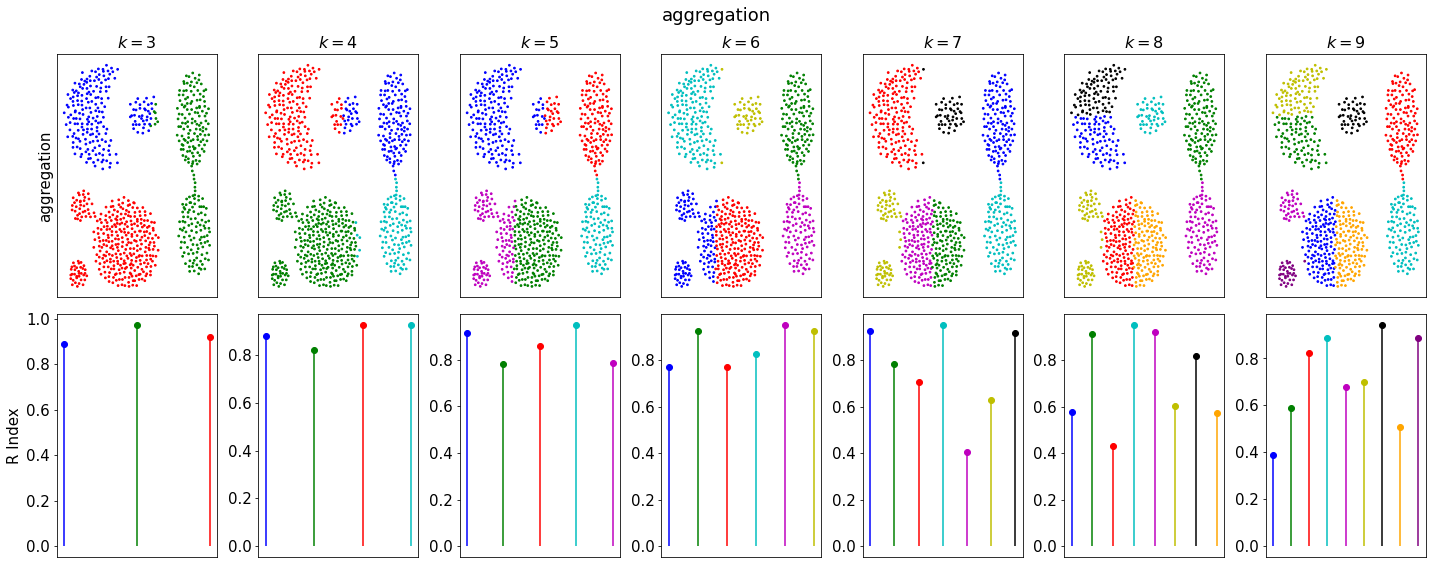

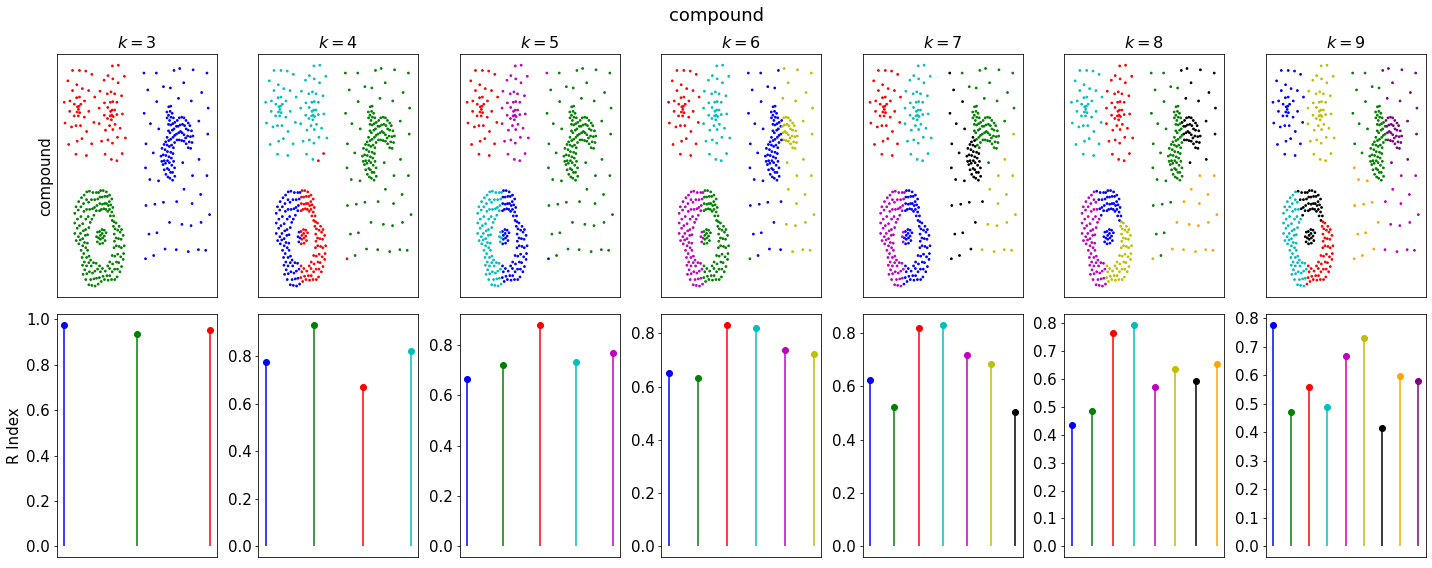

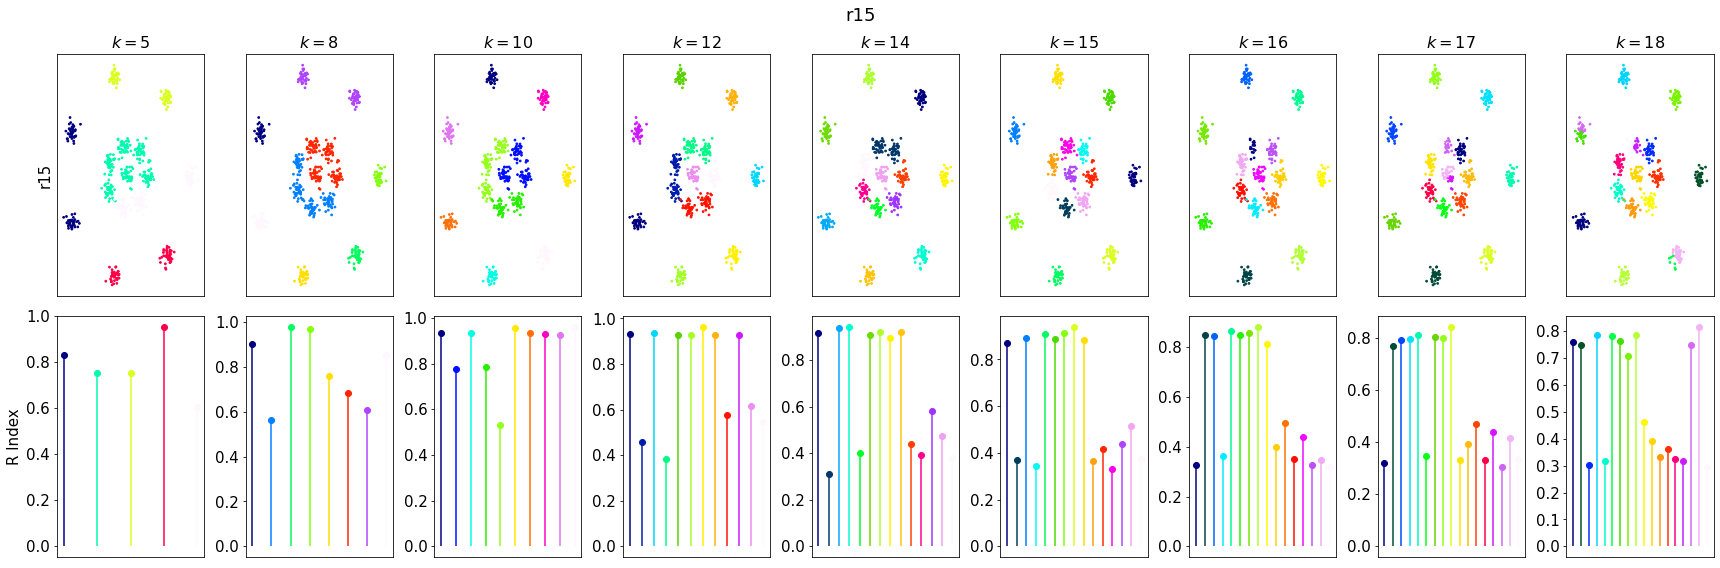

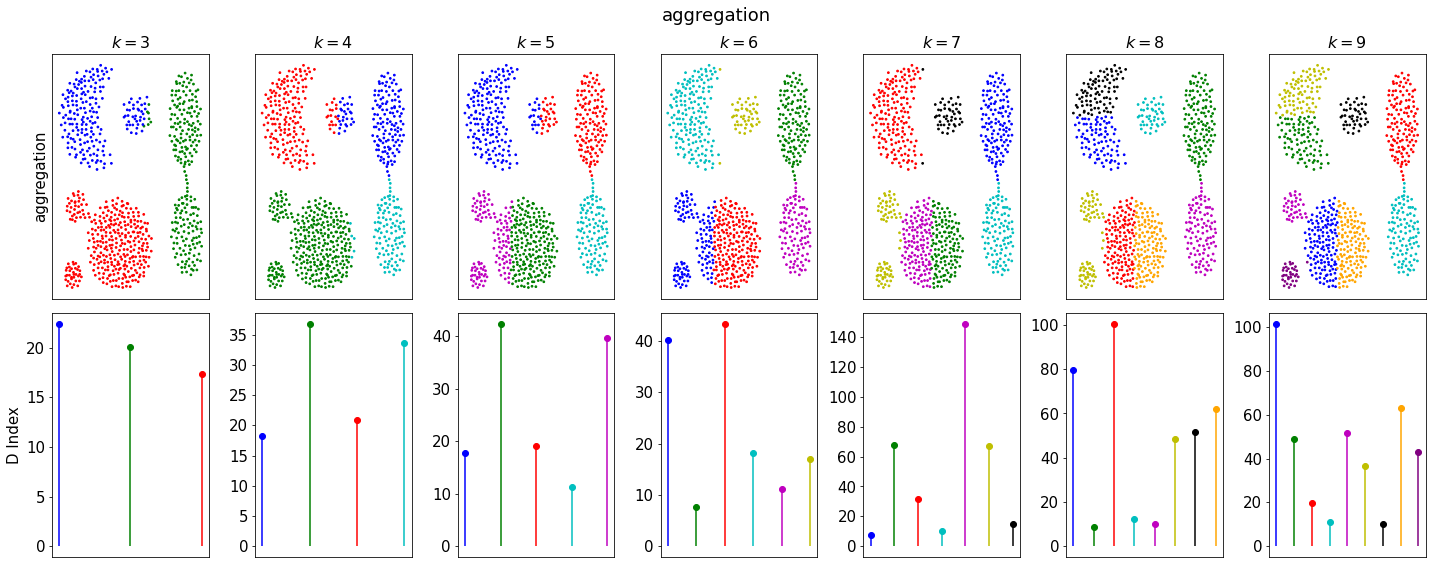

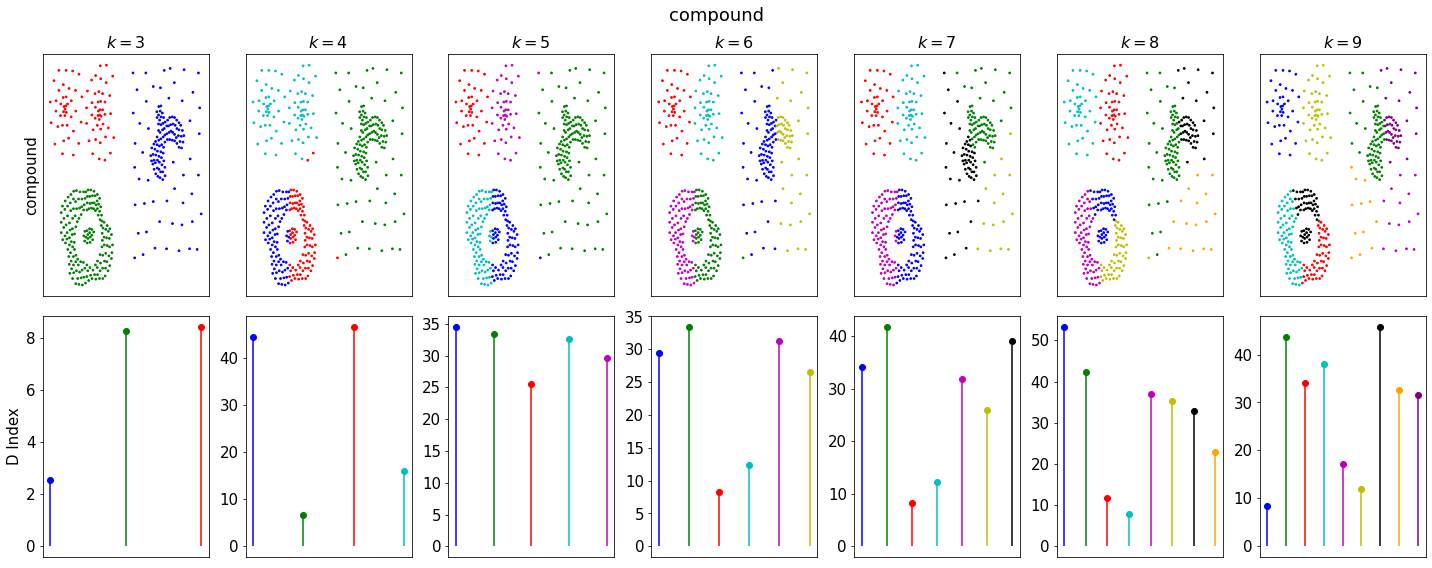

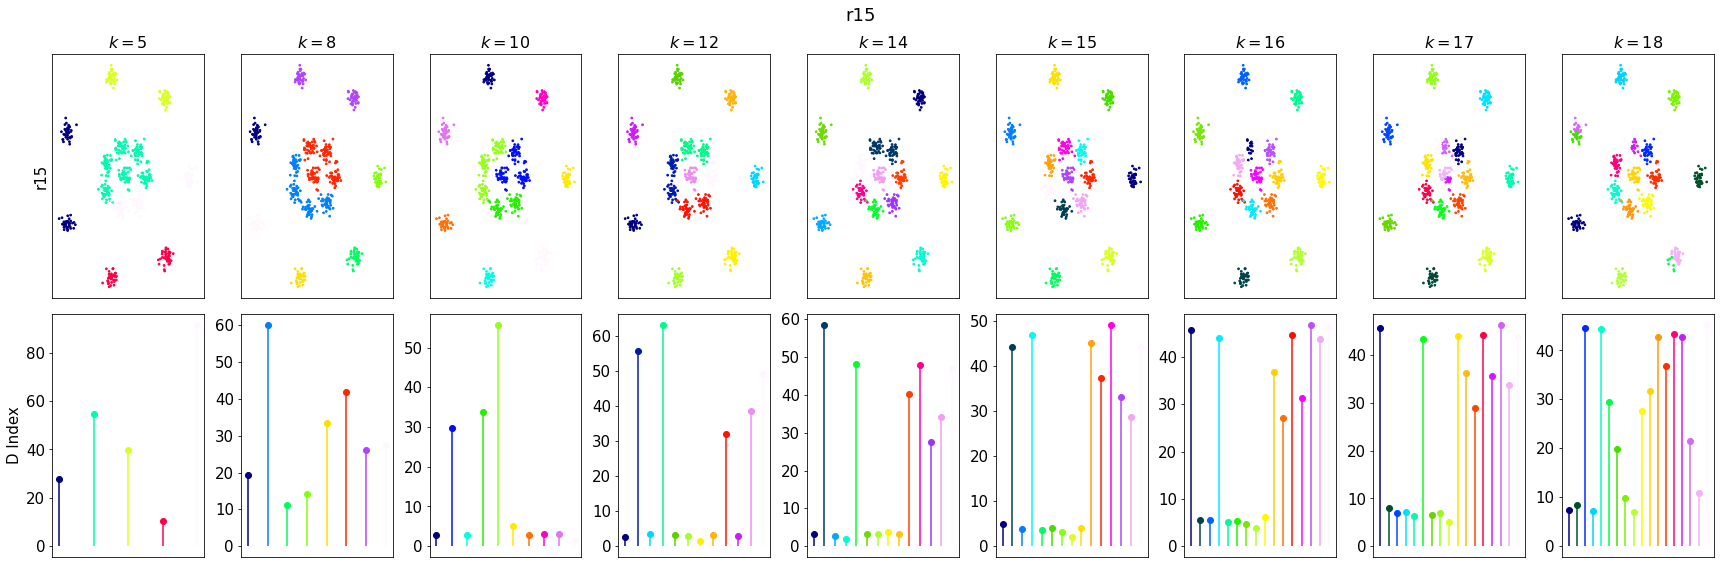

In [4]:
d_r_results = np.load('Additional_Experiments/d_r_scores_results.npy', allow_pickle=1).item()

c_ls = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple']
for dataset in ['aggregation', 'compound']:
    plt.figure(figsize = (20,8))
    data = shapes_datasets[dataset]
    ncols = len(d_r_results[dataset])
    
    for k, key in enumerate(d_r_results[dataset].keys()):

        labels = d_r_results[dataset][key]['labels']
        plt.subplot(2,ncols,k+1)

        plt.title(r'$k=$'+str(key), fontsize = 16)
        plt.scatter(data[:,0], data[:,1], color = [c_ls[l] for l in labels], s = 3)
        plt.xticks([], [])
        plt.yticks([], [])
        if k == 0:
            
            plt.ylabel(dataset, fontsize = 15)
        
        ax = plt.subplot(2,ncols,ncols+k+1)
        plt.yticks(fontsize = 15)
        for _ in range(len(np.unique(labels))):
            #plt.hist(smolkin_results[dataset][key]['score'][:,k], color = c_ls[k], alpha = .5)
            plt.scatter(x = _+1, y = d_r_results[dataset][key]['score_r'][:,_].mean(), color = c_ls[_])
            plt.vlines(x = _+1, ymin = 0, ymax = d_r_results[dataset][key]['score_r'][:,_].mean(), color = c_ls[_])
        plt.xticks([], [])
        if k == 0:
            
            plt.ylabel('R Index', fontsize = 15)
            
    plt.suptitle(dataset, fontsize = 18)
    plt.tight_layout()
    plt.savefig('Plots/stability_r_'+str(dataset)+'.pdf', dpi = 1000, bbox_inches = 'tight')
    plt.show()
    
dataset = 'r15'
plt.figure(figsize = (24,8))
data = shapes_datasets[dataset]
selected_cl = [5, 8, 10, 12, 14, 15, 16, 17, 18]
ncols = len(selected_cl)

for k, key in enumerate(selected_cl):
    c_ls = cm.gist_ncar(np.linspace(0, 1, key))
    labels = d_r_results[dataset][key]['labels']
    plt.subplot(2,ncols,k+1)

    plt.title(r'$k=$'+str(key), fontsize = 16)
    plt.scatter(data[:,0], data[:,1], color = [c_ls[l] for l in labels], s = 3)
    plt.xticks([], [])
    plt.yticks([], [])
    if k == 0:
        plt.ylabel(dataset, fontsize=15)
    ax = plt.subplot(2,ncols,ncols+k+1)
    plt.yticks(fontsize=15)
    for _ in range(len(np.unique(labels))):
        #plt.hist(smolkin_results[dataset][key]['score'][:,k], color = c_ls[k], alpha = .5)
        plt.scatter(x = _+1, y = d_r_results[dataset][key]['score_r'][:,_].mean(), color = c_ls[_])
        plt.vlines(x = _+1, ymin = 0, ymax = d_r_results[dataset][key]['score_r'][:,_].mean(), color = c_ls[_])
    plt.xticks([], [])
    if k == 0:
        plt.ylabel('R Index', fontsize = 15)
    plt.suptitle(dataset, fontsize = 18)

plt.tight_layout()
plt.savefig('Plots/stability_r_'+str(dataset)+'.pdf', dpi = 1000, bbox_inches = 'tight')
plt.show()


c_ls = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple']
for dataset in ['aggregation', 'compound']:
    plt.figure(figsize = (20,8))
    data = shapes_datasets[dataset]
    ncols = len(d_r_results[dataset])
    
    for k, key in enumerate(d_r_results[dataset].keys()):

        labels = d_r_results[dataset][key]['labels']
        plt.subplot(2,ncols,k+1)

        plt.title(r'$k=$'+str(key), fontsize = 16)
        plt.scatter(data[:,0], data[:,1], color = [c_ls[l] for l in labels], s = 3)
        plt.xticks([], [])
        plt.yticks([], [])
        if k == 0:
            
            plt.ylabel(dataset, fontsize = 15)
        
        ax = plt.subplot(2,ncols,ncols+k+1)
        plt.yticks(fontsize = 15)
        for _ in range(len(np.unique(labels))):
            #plt.hist(smolkin_results[dataset][key]['score'][:,k], color = c_ls[k], alpha = .5)
            plt.scatter(x = _+1, y = d_r_results[dataset][key]['score_d'][:,_].mean(), color = c_ls[_])
            plt.vlines(x = _+1, ymin = 0, ymax = d_r_results[dataset][key]['score_d'][:,_].mean(), color = c_ls[_])
        plt.xticks([], [])
        if k == 0:
            
            plt.ylabel('D Index', fontsize = 15)
            
    plt.suptitle(dataset, fontsize = 18)
    plt.tight_layout()
    plt.savefig('Plots/stability_d_'+str(dataset)+'.pdf', dpi = 1000, bbox_inches = 'tight')
    plt.show()
    
dataset = 'r15'
plt.figure(figsize = (24,8))
data = shapes_datasets[dataset]
selected_cl = [5, 8, 10, 12, 14, 15, 16, 17, 18]
ncols = len(selected_cl)

for k, key in enumerate(selected_cl):
    c_ls = cm.gist_ncar(np.linspace(0, 1, key))
    labels = d_r_results[dataset][key]['labels']
    plt.subplot(2,ncols,k+1)

    plt.title(r'$k=$'+str(key), fontsize = 16)
    plt.scatter(data[:,0], data[:,1], color = [c_ls[l] for l in labels], s = 3)
    plt.xticks([], [])
    plt.yticks([], [])
    if k == 0:
        plt.ylabel(dataset, fontsize=15)
    ax = plt.subplot(2,ncols,ncols+k+1)
    plt.yticks(fontsize=15)
    for _ in range(len(np.unique(labels))):
        #plt.hist(smolkin_results[dataset][key]['score'][:,k], color = c_ls[k], alpha = .5)
        plt.scatter(x = _+1, y = d_r_results[dataset][key]['score_d'][:,_].mean(), color = c_ls[_])
        plt.vlines(x = _+1, ymin = 0, ymax = d_r_results[dataset][key]['score_d'][:,_].mean(), color = c_ls[_])
    plt.xticks([], [])
    if k == 0:
        plt.ylabel('D Index', fontsize = 15)
    plt.suptitle(dataset, fontsize = 18)

plt.tight_layout()
plt.savefig('Plots/stability_d_'+str(dataset)+'.pdf', dpi = 1000, bbox_inches = 'tight')
plt.show()